This is my first attempt at building a CNN inspired by the LeNet architecture. The Lenet architecture consists of two sets of convolutional and pooling layers, followed by two fully connected layers. Let's get to building!

Before we get to building, we need to generate data. So far, I have generated data from the following datasets:
* i3c3a1d0v5a0_set18a
* i3c3a1d0v5a0_set18b
* i3c3a1d0v5a0_set18d
* i3c3a1d0v5a2_set21
* i3c3a1d0v5a7_set21
* i3c3a1d0v5a14_set21
* i3c3a1d0v5a15_set21
* i3c3a1d1v5a0_set22
* i3c3a1d1v5a7_set22
* i3c4a1d0v5a0_set20
* i3c4a1d0v5a0_set23
* i3c5a1d0v5a0_set20
* i3c5a1d0v5a0_set23
* i3c3a0d0v5a2_set17 - bad data set, ignore
* i3c3a0d1v5a2_set17 - also bad data set, ignore 
The two last datasets are deemed as "bad" because they did not have any T1 transitions. I suspect that something was weird with the data generation process from the master code, but I am not sure. 

Firstly, import the necessary libraries. These ones are pretty standard, courtesy of Harish's notebook for generating the dataset.

In [95]:
# from phasefield_scripts.load_files import *
# from phasefield_scripts.procedures import *
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import ipywidgets as widget
from ipywidgets import fixed
import os
import pickle
import multiprocessing as mp
from tqdm import tqdm
from multiprocessing import Pool
%matplotlib widget
import pandas as pd
import numpy as np 
import seaborn as sns


Import Torch libraries to make building the CNN a lot easier.

In [60]:
import torch
import torchvision
from torchvision import transforms
# from torchvision.datasets import ImageFolder

Sanity check to check the dimensions of your original images: 

In [61]:
from PIL import Image
import os

data_dir = 'data_CNN_ready\\' + 'T0_all'

# Loop through all images in the data directory
for filename in os.listdir(data_dir):
    img_path = os.path.join(data_dir, filename)
    with Image.open(img_path) as img:
        width, height = img.size
        print(f"Image size for {filename}: {width} x {height}")

Image size for img00000.png: 150 x 150
Image size for img00000_1.png: 150 x 150
Image size for img00000_2.png: 150 x 150
Image size for img00000_3.png: 150 x 150
Image size for img00000_4.png: 150 x 150
Image size for img00000_5.png: 150 x 150
Image size for img00000_6.png: 150 x 150
Image size for img00000_7.png: 150 x 150
Image size for img00000_8.png: 150 x 150
Image size for img00001.png: 150 x 150
Image size for img00001_1.png: 150 x 150
Image size for img00001_10.png: 150 x 150
Image size for img00001_2.png: 150 x 150
Image size for img00001_3.png: 150 x 150
Image size for img00001_4.png: 150 x 150
Image size for img00001_5.png: 150 x 150
Image size for img00001_6.png: 150 x 150
Image size for img00001_7.png: 150 x 150
Image size for img00001_8.png: 150 x 150
Image size for img00001_9.png: 150 x 150
Image size for img00002.png: 150 x 150
Image size for img00002_1.png: 150 x 150
Image size for img00002_10.png: 150 x 150
Image size for img00002_2.png: 150 x 150
Image size for img00

Now, time to import your dataset. This took me some time, but I have sorted my images into folders with T1 transitions and no T2 transitions (T0). Now, using torch's ImageFolder class, I can import the images into a dataset. I have also used the transforms class to resize the images to 32x32 pixels, and convert them to tensors. This is necessary for the CNN to work.

In [62]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

# define the path to the data directory
data_dir = 'data_CNN_ready\\'

# define the transformations to be applied to the images
transform = transforms.Compose([
    # transforms.Resize((224, 224)),  #this will resize images to 224x224 but I am not sure if this is necessary
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# create the ImageFolder dataset
dataset = ImageFolder(data_dir, transform=transform) #subdirectories are the classes: T0 = 0 and T1 = 1

print(dataset.classes)


# split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# create the data loaders for the train and validation sets
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size) #shuffle = False here, this is apparently better for validation data 

# print the number of samples in the train and validation sets
print(f"Number of samples in train set: {len(train_dataset)}")
print(f"Number of samples in validation set: {len(val_dataset)}")




['T0_all', 'T1_all']
Number of samples in train set: 520
Number of samples in validation set: 130


In [63]:

# assume train_loader and val_loader are the data loaders for your train and validation datasets
for i, (inputs, labels) in enumerate(train_loader):
    # inputs is a tensor of shape [batch_size, channels, height, width]
    print(f"Train batch {i}: {inputs.shape}")
    # labels is a tensor of shape [batch_size]
    print(f"Train labels {i}: {labels.shape}")

for i, (inputs, labels) in enumerate(val_loader):
    # inputs is a tensor of shape [batch_size, channels, height, width]
    print(f"Val batch {i}: {inputs.shape}")
    # labels is a tensor of shape [batch_size]
    print(f"Val labels {i}: {labels.shape}")


Train batch 0: torch.Size([16, 1, 150, 150])
Train labels 0: torch.Size([16])
Train batch 1: torch.Size([16, 1, 150, 150])
Train labels 1: torch.Size([16])
Train batch 2: torch.Size([16, 1, 150, 150])
Train labels 2: torch.Size([16])
Train batch 3: torch.Size([16, 1, 150, 150])
Train labels 3: torch.Size([16])
Train batch 4: torch.Size([16, 1, 150, 150])
Train labels 4: torch.Size([16])
Train batch 5: torch.Size([16, 1, 150, 150])
Train labels 5: torch.Size([16])
Train batch 6: torch.Size([16, 1, 150, 150])
Train labels 6: torch.Size([16])
Train batch 7: torch.Size([16, 1, 150, 150])
Train labels 7: torch.Size([16])
Train batch 8: torch.Size([16, 1, 150, 150])
Train labels 8: torch.Size([16])
Train batch 9: torch.Size([16, 1, 150, 150])
Train labels 9: torch.Size([16])
Train batch 10: torch.Size([16, 1, 150, 150])
Train labels 10: torch.Size([16])
Train batch 11: torch.Size([16, 1, 150, 150])
Train labels 11: torch.Size([16])
Train batch 12: torch.Size([16, 1, 150, 150])
Train labels 1

In [64]:
# print the names of the classes
print(dataset.classes)

# iterate over the train loader and check the labels
for images, labels in train_loader:
    for label in labels:
        print(dataset.classes[label])
        
# iterate over the validation loader and check the labels
for images, labels in val_loader:
    for label in labels:
        print(dataset.classes[label])



['T0_all', 'T1_all']
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T1_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T1_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T1_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T1_all
T1_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T1_all
T0_all
T0_all
T1_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T1_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T0_all
T1_all
T0_all
T0_all
T0_all
T0_all
T0_all
T1_all
T0_all
T0_all
T0_all

In [65]:
# initialize counters for T0 and T1 classes
num_t0 = 0
num_t1 = 0

# iterate over the train loader and count the number of data points for each class
for _, labels in train_loader:
    for label in labels:
        if label == 0:
            num_t0 += 1
        elif label == 1:
            num_t1 += 1

# print the number of data points for each class
print(f"Number of T0 data points in train set: {num_t0}")
print(f"Number of T1 data points in train set: {num_t1}")


Number of T0 data points in train set: 460
Number of T1 data points in train set: 60


In [66]:
num_t0 = 0
num_t1 = 0

# iterate over the train loader and count the number of data points for each class
for _, labels in val_loader:
    for label in labels:
        if label == 0:
            num_t0 += 1
        elif label == 1:
            num_t1 += 1

# print the number of data points for each class
print(f"Number of T0 data points in valid set: {num_t0}")
print(f"Number of T1 data points in valid set: {num_t1}")


Number of T0 data points in valid set: 117
Number of T1 data points in valid set: 13


OK, at least we have now loaded the dataset, and have split it into training and validation sets. Now, let's build the CNN. I have used the LeNet architecture as a guide, but have made some changes. Firstly, I have used 3 convolutional layers instead of 2, and have used 2 fully connected layers instead of 3. I have also used a dropout layer after the first fully connected layer. This is to prevent overfitting. I have also used a ReLU activation function after each convolutional layer, and a sigmoid activation function after the final fully connected layer. This is because I am using binary cross entropy loss, and the sigmoid function will output a value between 0 and 1, which is what we want. I have also used a softmax activation function after the first fully connected layer, as this is a multi-class classification problem.

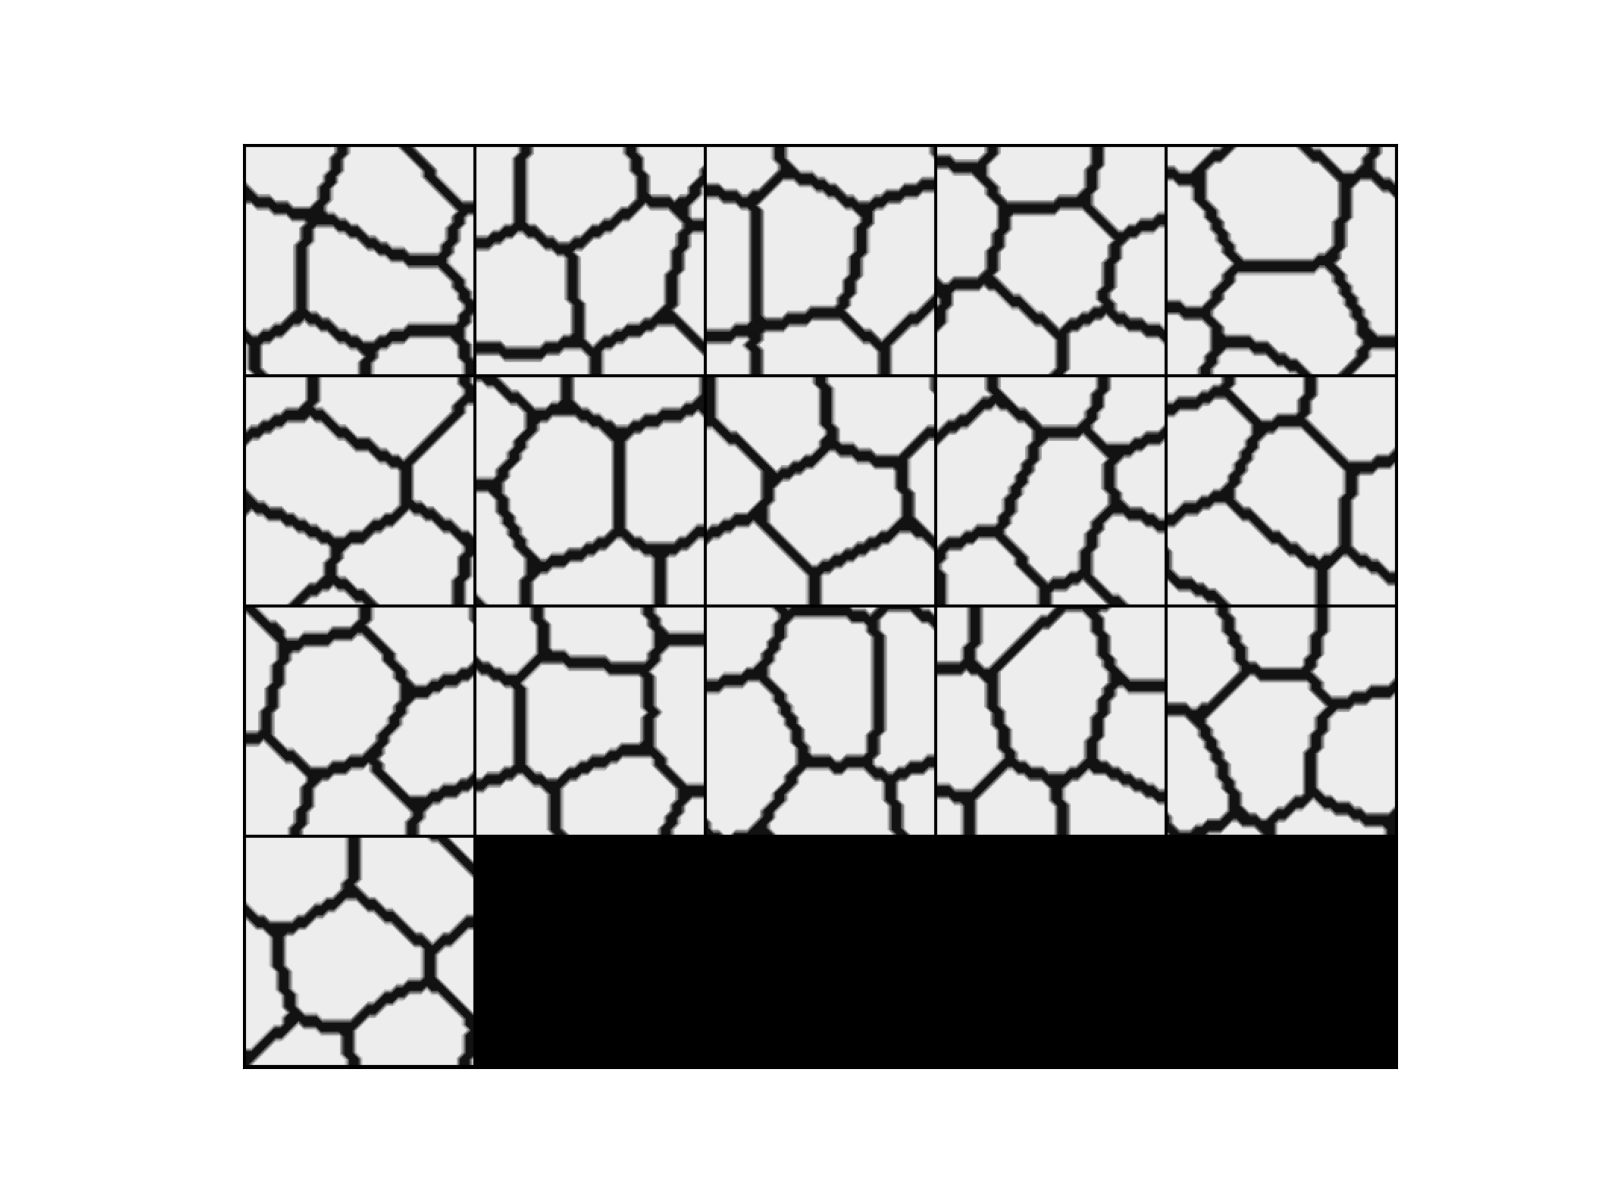

In [67]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=5).permute(1,2,0))
        break
        
show_batch(train_loader)

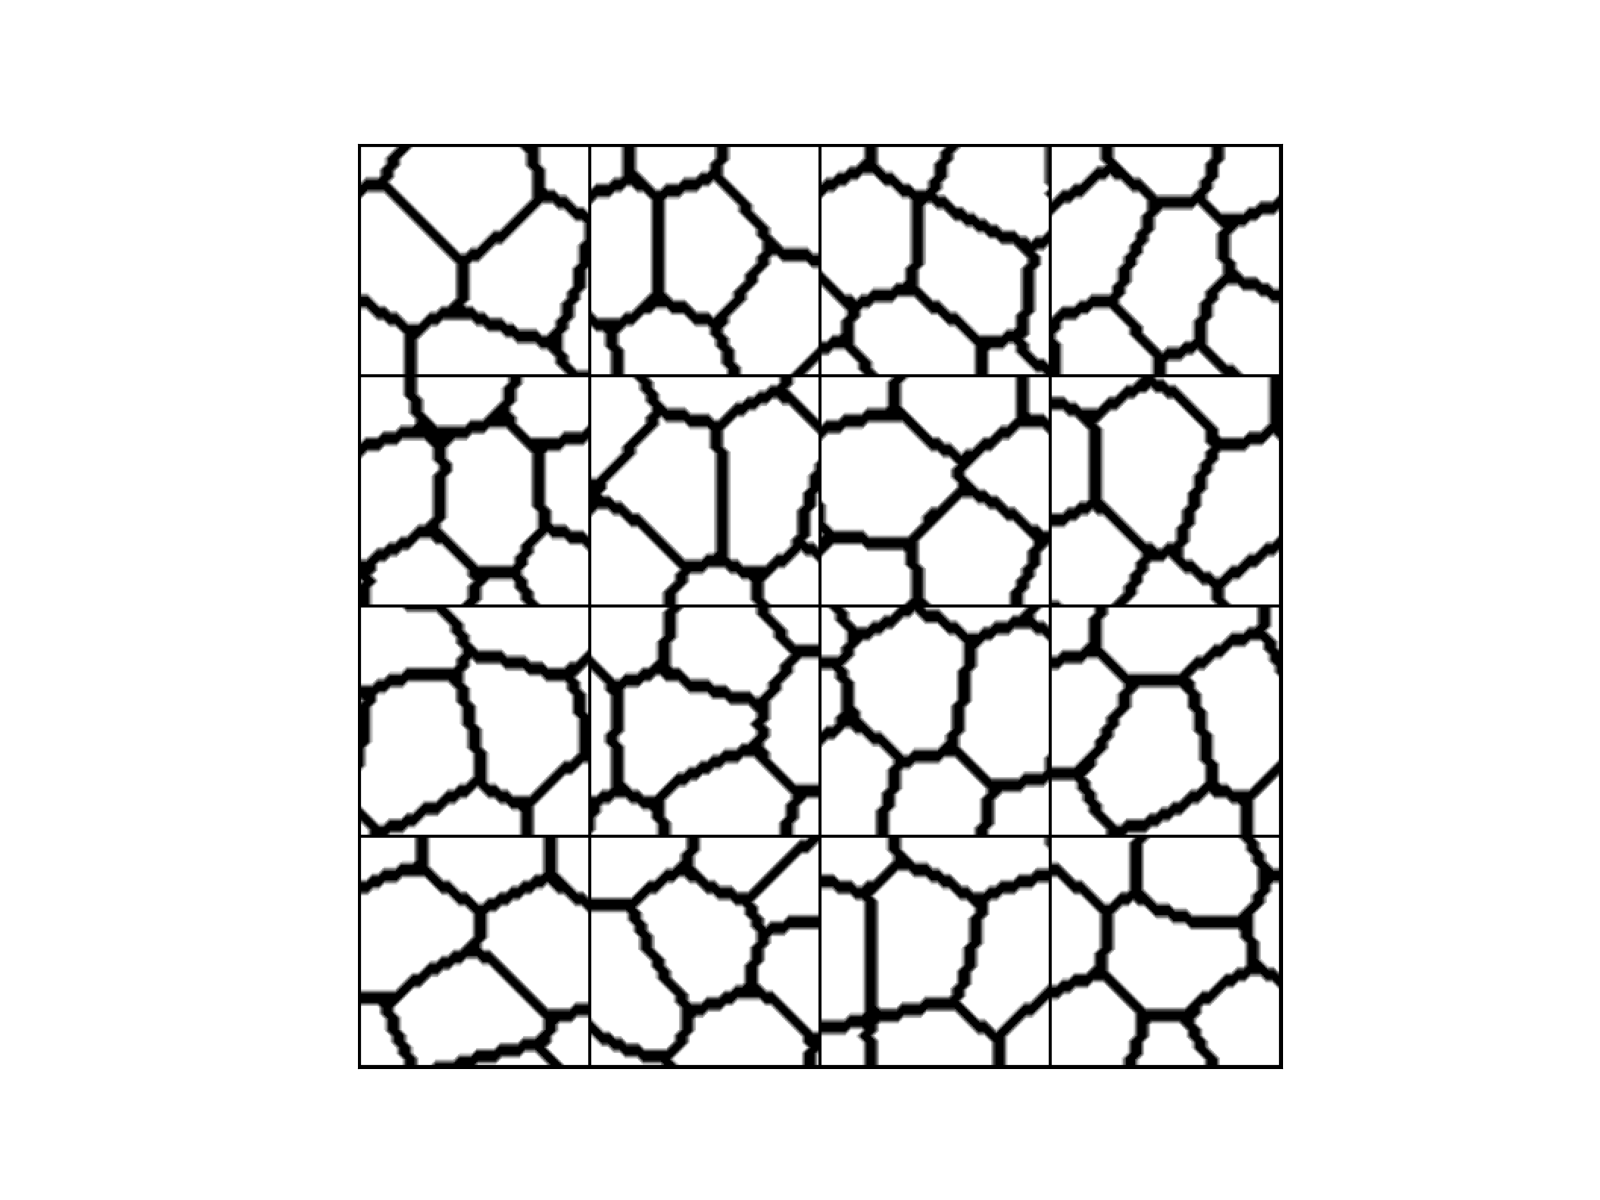

In [73]:
import torchvision.utils as vutils

# get a batch of images from train_loader
batch = next(iter(train_loader))

# create a grid of images
grid = vutils.make_grid(batch[0], nrow=4, padding=2, normalize=True)

# convert the tensor grid to numpy array
images = np.transpose(grid.numpy(), (1, 2, 0))

# show the images
plt.imshow(images)
plt.show()

In [83]:
import torch.nn as nn
import torch.nn.functional as F

# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         # self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_output_channels=12):
        super().__init__()
        self.conv1 = nn.Conv2d(1, num_output_channels, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(num_output_channels, 32, 5)
        self.fc1 = nn.Linear(32 * 34 * 34, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net(num_output_channels=12) # specify the number of output channels here


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}')


print('Finished Training')


[1,     1] loss: 2.319
[1,     2] loss: 2.314
[1,     3] loss: 2.305
[1,     4] loss: 2.293
[1,     5] loss: 2.277
[1,     6] loss: 2.259
[1,     7] loss: 2.245
[1,     8] loss: 2.224
[1,     9] loss: 2.198
[1,    10] loss: 2.168
[1,    11] loss: 2.131
[1,    12] loss: 2.083
[1,    13] loss: 2.031
[1,    14] loss: 1.969
[1,    15] loss: 1.909
[1,    16] loss: 1.836
[1,    17] loss: 1.736
[1,    18] loss: 1.679
[1,    19] loss: 1.592
[1,    20] loss: 1.536
[1,    21] loss: 1.512
[1,    22] loss: 1.518
[1,    23] loss: 1.499
[1,    24] loss: 1.458
[1,    25] loss: 1.474
[1,    26] loss: 1.433
[1,    27] loss: 1.392
[1,    28] loss: 1.371
[1,    29] loss: 1.332
[1,    30] loss: 1.302
[1,    31] loss: 1.278
[1,    32] loss: 1.256
[1,    33] loss: 1.235
[2,     1] loss: 0.679
[2,     2] loss: 0.627
[2,     3] loss: 0.603
[2,     4] loss: 0.562
[2,     5] loss: 0.514
[2,     6] loss: 0.480
[2,     7] loss: 0.469
[2,     8] loss: 0.463
[2,     9] loss: 0.462
[2,    10] loss: 0.466
[2,    11] 

In [84]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [88]:
net = Net()
net.load_state_dict(torch.load(PATH))

dataiter = iter(val_loader)
images, labels = next(dataiter)


outputs = net(images)


Accuracy on validation set: 90 %
[[117   0]
 [ 13   0]]


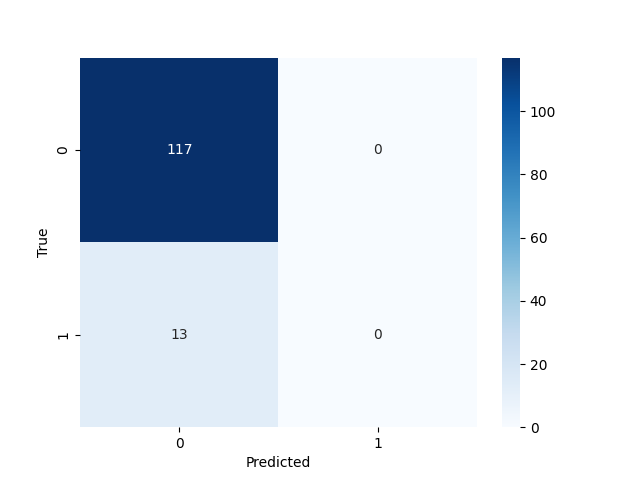

In [96]:
from sklearn.metrics import confusion_matrix

correct = 0
total = 0

y_true = []
y_pred = []


with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        
confusion_mat = confusion_matrix(y_true, y_pred)

print('Accuracy on validation set: %d %%' % (100 * correct / total))
print(confusion_mat)

# Create a heatmap of the confusion matrix
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')

# Set the axis labels
plt.xlabel('Predicted')
plt.ylabel('True')

# Show the plot
plt.show()
